In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# datajoint is only for showing extracted sample traces from the raw movies.
try:
    %cd '/home/rozmar/Scripts/Python/DataPipeline'
    import datajoint as dj
    dj.conn()
    from pipeline import pipeline_tools
    from pipeline import lab, experiment, ephys_patch, ephysanal, imaging, imaging_gt
except:
    print('no datajoint, ophys traces won''t be shown')

/home/rozmar/Scripts/Python/DataPipeline
Connecting rozmar@mesoscale-activity.datajoint.io:3306


# Accessing a movie data and metadata
The data is arranged in subfolders: /'subject_id'/'cell_id'/'movie_name'/

select subject, cell and movie based on the directory structure:

In [2]:
ground_truth_basedir = '/home/rozmar/Data/Voltage_imaging/ground_truth' # location of the data
subject_id = '456462'
cell_id = 'Cell_5'
movie  = '40x_1xtube_10A5'
movie_dir = os.path.join(ground_truth_basedir , subject_id , cell_id , movie)
movie_dir

'/home/rozmar/Data/Voltage_imaging/ground_truth/456462/Cell_5/40x_1xtube_10A5'

The movie metadata (framerate, pixel size) is in the movie_metadata.json file in the main movie directory.

In [3]:
with open(os.path.join(movie_dir,'movie_metadata.json')) as json_file:
    movie_metadata = json.load(json_file)
movie_metadata

{'movie_frame_num': 50000,
 'movie_frame_rate': 401.60642570281124,
 'movie_name': '40x_1xtube_10A5',
 'movie_number': 3,
 'movie_pixel_size': 0.59,
 'movie_start_time': 376.2986300000048,
 'movie_x_size': 512.0,
 'movie_y_size': 128.0,
 'session': 1,
 'subject_id': 456462}

The actual movie files are in the movie subfolder, these are multitiff files chunked to 300MB each

In [4]:
movie_files_dir = os.path.join(movie_dir,'movie')
movie_files = os.listdir(movie_files_dir)
sorted(movie_files)

['40x_1xtube_10A5_000.tif',
 '40x_1xtube_10A5_001.tif',
 '40x_1xtube_10A5_002.tif',
 '40x_1xtube_10A5_003.tif',
 '40x_1xtube_10A5_004.tif',
 '40x_1xtube_10A5_005.tif',
 '40x_1xtube_10A5_006.tif',
 '40x_1xtube_10A5_007.tif',
 '40x_1xtube_10A5_008.tif',
 '40x_1xtube_10A5_009.tif',
 '40x_1xtube_10A5_010.tif',
 '40x_1xtube_10A5_011.tif',
 '40x_1xtube_10A5_012.tif',
 '40x_1xtube_10A5_013.tif',
 '40x_1xtube_10A5_014.tif',
 '40x_1xtube_10A5_015.tif',
 '40x_1xtube_10A5_016.tif',
 '40x_1xtube_10A5_017.tif',
 '40x_1xtube_10A5_018.tif',
 '40x_1xtube_10A5_019.tif',
 '40x_1xtube_10A5_020.tif',
 '40x_1xtube_10A5_021.tif']

The frame times (relative to the ephys recording) is in the frame_times.npy file.

In [5]:
frame_times = np.load(os.path.join(movie_dir,'frame_times.npy'))
frame_times

array([376.29863 , 376.301125, 376.30362 , ..., 501.014343, 501.016833,
       501.019328])

In [6]:
# an example digested ROI from datajoint
try:
    key_roi = {'subject_id': movie_metadata['subject_id'],
               'session': movie_metadata['session'],
               'movie_number': movie_metadata['movie_number'],
               'motion_correction_method': 'Matlab',
               'roi_type': 'SpikePursuit'}
    dff,gt_roi_num = (imaging_gt.GroundTruthROI()*imaging_gt.imaging.ROI()&key_roi).fetch1('roi_dff','roi_number')
    dff_all, roi_number_all = (imaging_gt.imaging.ROI()&key_roi).fetch('roi_dff','roi_number')
    dff_all =dff_all[roi_number_all!=gt_roi_num]
    dff_list = [dff]
    dff_list.extend(dff_all)
except:
    print('no datajoint, ophys traces won''t be shown')
    dff = None


# Accessing the ephys data
The ephys files are in the ephys subfolder.

In [7]:
ephys_files_dir = os.path.join(movie_dir,'ephys')
ephys_files = sorted(os.listdir(ephys_files_dir))
ephys_files

['sweep_56.json',
 'sweep_56.npz',
 'sweep_57.json',
 'sweep_57.npz',
 'sweep_58.json',
 'sweep_58.npz',
 'sweep_59.json',
 'sweep_59.npz',
 'sweep_60.json',
 'sweep_60.npz']

Reading the sweeps is just iterating over the files

In [8]:
sweep_time = list()
sweep_response = list()
sweep_stimulus = list()
sweep_metadata = list()
for ephys_file in ephys_files:
    if ephys_file[-3:]=='npz':
        data_dict = np.load(os.path.join(ephys_files_dir,ephys_file))
        sweep_time.append(data_dict['time'])
        sweep_response.append(data_dict['voltage'])
        sweep_stimulus.append(data_dict['stimulus'])
        with open(os.path.join(ephys_files_dir,ephys_file[:-3]+'json')) as json_file:
            sweep_metadata.append(json.load(json_file))     
sweep_metadata[0] # here is an example of a sweep metadata

{'bridgebalenable': 1,
 'bridgebalresist': 50000000.0,
 'cell_number': 5,
 'data_header': ['time', 'voltage', 'stimulus'],
 'data_units': ['s', 'mV', 'pA'],
 'fastcompcap': 8.4134e-42,
 'fastcomptau': 8.4134e-42,
 'holding': 0.0,
 'holdingenable': 0,
 'leaksubenable': 1,
 'leaksubresist': 8.4134e-42,
 'ljp': 13.5,
 'ljp_corrected': True,
 'neutralizationcap': 6.02496e-12,
 'neutralizationenable': 1,
 'outputzeroamplitude': 0.0,
 'outputzeroenable': 0,
 'pipetteoffset': -0.0711719,
 'primarysignalhpf': 0.0,
 'primarysignallpf': 21000.0,
 'protocol_name': 'cont_001',
 'protocol_sweep_number': 0,
 'recording_mode': 'current clamp',
 'rscompbandwidth': 8.4134e-42,
 'rscompcorrection': 8.4134e-42,
 'rscompenable': 1,
 'sample_rate': 10000,
 'session': 1,
 'slowcompcap': 8.4134e-42,
 'slowcomptau': 8.4134e-42,
 'subject_id': 456462,
 'sweep_end_time': 388.86945,
 'sweep_number': 56,
 'sweep_start_time': 358.869455,
 'wholecellcompcap': 8.4134e-42,
 'wholecellcompenable': 1,
 'wholecellcompre

# Plotting ephys and ophys data.

Text(0, 0.5, 'Stimulus (pA)')

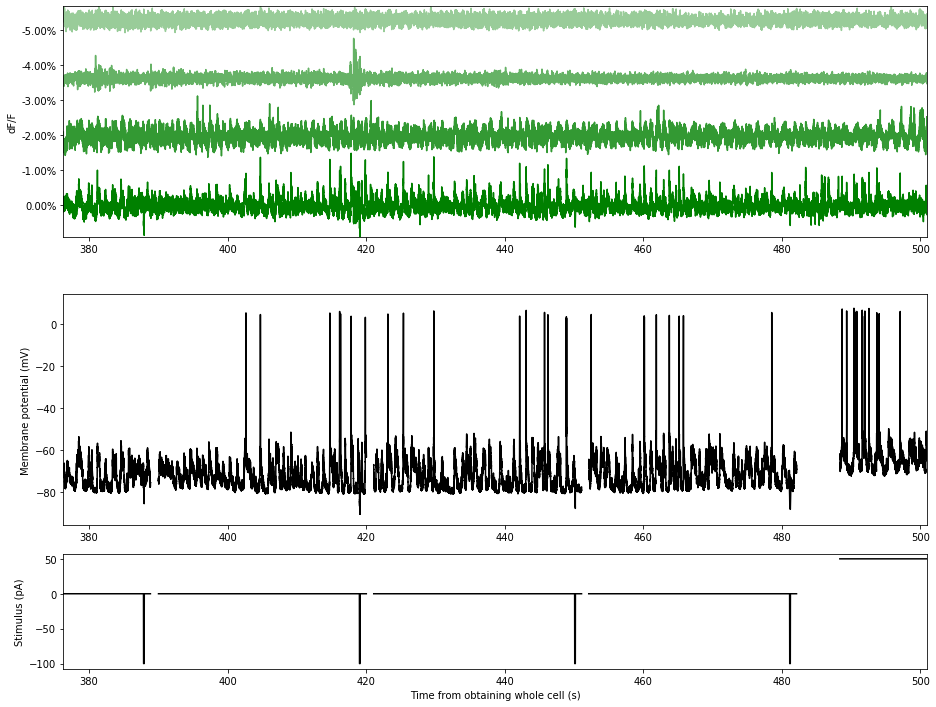

In [9]:
fig=plt.figure()
ax_ephys = fig.add_axes([0,0,2,.8])
ax_stim = fig.add_axes([0,-.5,2,.4])
for time,response,stimulus in zip(sweep_time,sweep_response,sweep_stimulus):
    ax_ephys.plot(time,response,'k-')
    ax_stim.plot(time,stimulus,'k-')
if dff is not None:
    ax_ophys = fig.add_axes([0,1,2,.8])
    
    prevminval = 0
    for dff_now,alpha_now in zip(dff_list,np.arange(1,1/(len(dff_list)+1),-1/(len(dff_list)+1))):
        dfftoplotnow = dff_now + prevminval
        ax_ophys.plot(frame_times,dfftoplotnow,'g-',alpha=alpha_now)
        prevminval = np.min(dfftoplotnow) -.005
    #ax_ophys.plot(frame_times,dff,'g-')
    ax_ophys.autoscale(tight = True)
    ax_ophys.invert_yaxis()
    ax_ophys.set_xlim([frame_times[0],frame_times[-1]])
    ax_ophys.set_ylabel('dF/F')
    vals = ax_ophys.get_yticks()
    ax_ophys.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    
ax_ephys.set_xlim([frame_times[0],frame_times[-1]])
ax_ephys.set_ylabel('Membrane potential (mV)')
ax_stim.set_xlim([frame_times[0],frame_times[-1]])
ax_stim.set_xlabel('Time from obtaining whole cell (s)')
ax_stim.set_ylabel('Stimulus (pA)')